## PCA

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, x):
        self.mean = np.mean(x, axis=0)
        x_centered = x - self.mean #centering the data
        
        cov_matrix = np.cov(x_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        idx = np.argsort(eigenvalues)[::-1] # Sorting the eigenvalues and eigenvectors
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        self.components = eigenvectors[:, :self.n_components] #first n components
        self.explained_variance = eigenvalues[:self.n_components]
        self.explained_variance_ratio = self.explained_variance / np.sum(eigenvalues)
        
        return self
        
    def transform(self, x):
        x_centered = x - self.mean
        x_transformed = np.dot(x_centered, self.components) #project the data
        return x_transformed
    
    def inverse_transform(self, x_transformed):
        x_reconstructed = np.dot(x_transformed, self.components.T) + self.mean #project back to original
        return x_reconstructed


In [4]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [8]:
def sample_balanced_data(dataset, n_samples):
    class_indices = {}
    for idx, (sample, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    samples_per_class = n_samples // len(class_indices)
    
    sampled_indices = []
    for label in class_indices:
        sampled_indices.extend(np.random.choice(class_indices[label], samples_per_class, replace=False))
    
    images = []
    labels = []
    for idx in sampled_indices:
        img, label = dataset[idx]
        images.append(img.numpy().flatten())
        labels.append(label)
    
    return np.array(images), np.array(labels)

In [10]:
x_sample, y_sample = sample_balanced_data(train_dataset, 1000)
print(x_sample.shape)
print(y_sample.shape)

(1000, 784)
(1000,)


In [11]:
scaler = StandardScaler()
x_sample_scaled = scaler.fit_transform(x_sample)

In [12]:
dimensions = [500, 300, 150, 30]
explained_variance_ratios = []

for dim in dimensions:
    pca = PCA(dim)
    pca.fit(x_sample_scaled)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio))

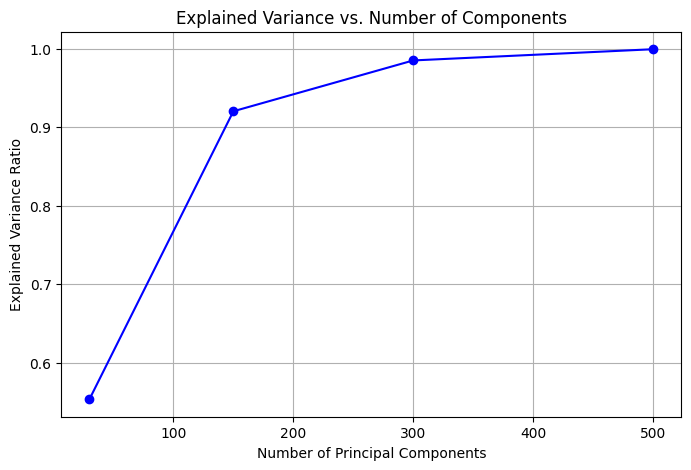

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(dimensions, explained_variance_ratios, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

#### Observations

The explained Variance Ratio Represents the proportion of total variance retained by the selected principal components.

Using fewer components (e.g., 30) loses a lot of variance, while using more (e.g., 300) retains almost all information.
The curve flattens at around 150-300 components, meaning after this point, adding more components doesn't significantly improve explained variance.

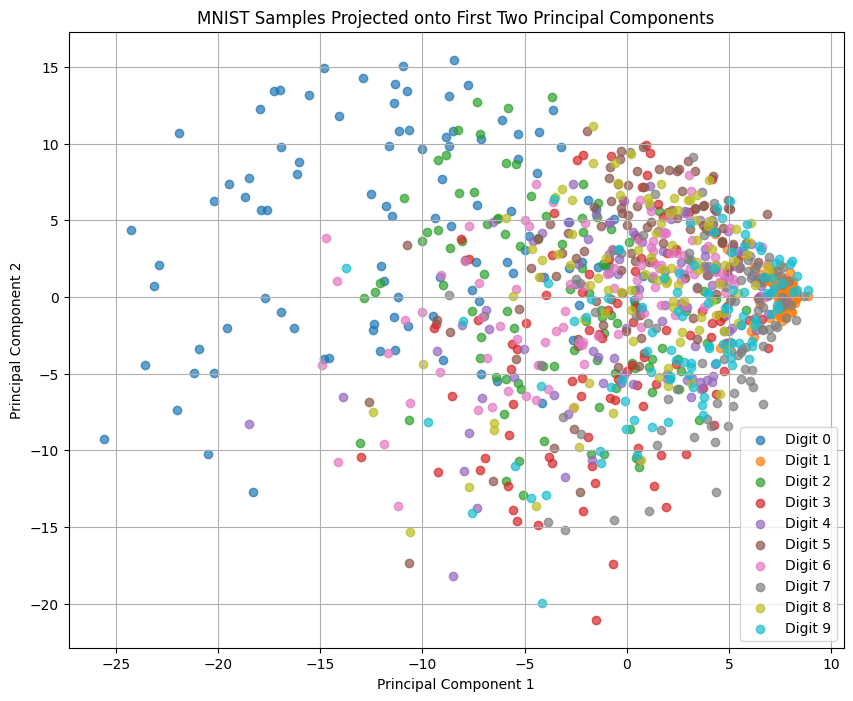

In [42]:
dim=2 # for 2D Plot
pca = PCA(dim)
pca.fit(x_sample_scaled)
x_reconstructed=pca.transform(x_sample_scaled)

plt.figure(figsize=(10, 8))
for i in range(10):  # 10 classes in MNIST
    plt.scatter(x_reconstructed[y_sample == i, 0], x_reconstructed[y_sample == i, 1], label=f'Digit {i}', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST Samples Projected onto First Two Principal Components')
plt.legend()
plt.grid(True)
plt.savefig('pca_2d_visualization.png')
plt.show()
plt.close()

#### Observations

1. Some digit classes form distinct clusters, while others overlap significantly. For example, digit '0' (blue) appears more spread out, while digits like '1' (orange) are more concentrated.

2. There is a noticeable overlap among different digit classes, especially around the central dense region. This implies some digits share similar feature representations in the first two principal components.

3. The digit '0' has several outliers positioned far from the main cluster. This may indicate variations in how '0' is written, leading to significant differences in its projection. Also digit '0' has most points are spread along PC2, it means the second component explains the majority of variance.

4. Some digits like '1' might be easier to classify due to their compact representation. Others, like '3' and '8', appear mixed with other digits, suggesting possible classification errors.

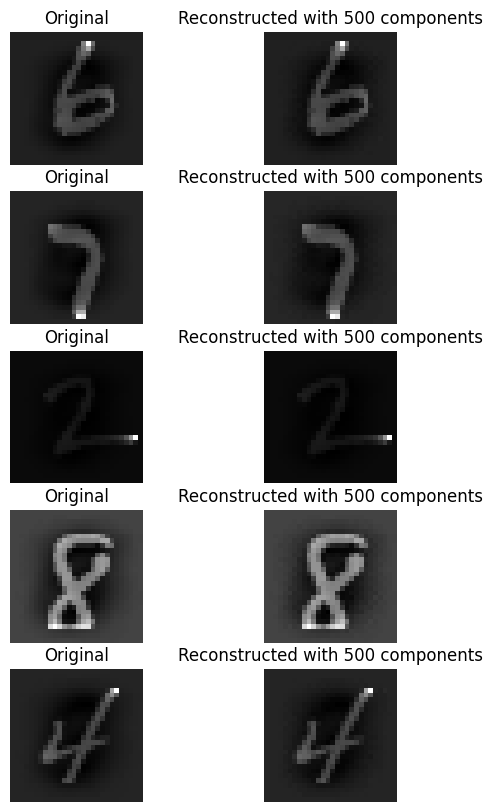

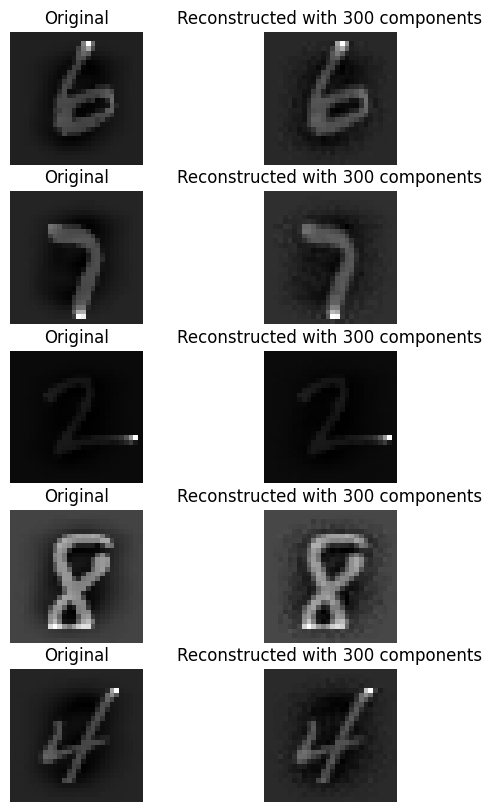

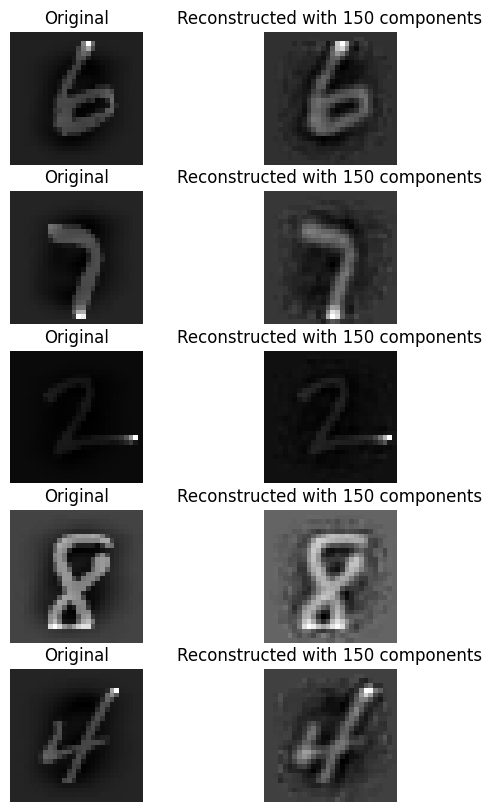

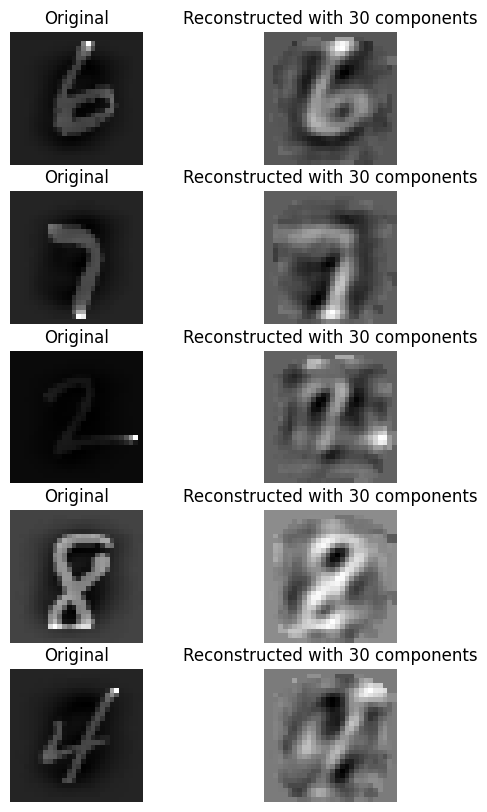

In [44]:
import random
def plot_images(original, reconstructed, n_images=5, title="Reconstructed Images"):
    fig, axes = plt.subplots(n_images, 2, figsize=(6, 10))
    for i in range(n_images):
        # Original image
        axes[i, 0].imshow(original[i].reshape(28, 28), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original")

        # Reconstructed image
        axes[i, 1].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(title)
    
    plt.show()

sample_indices = random.sample(range(len(x_sample_scaled)), 5)
x_sample = x_sample_scaled[sample_indices]

for dim in [500, 300, 150, 30]:
    pca = PCA(n_components=dim)
    pca.fit(x_sample_scaled)
    
    x_proj = pca.transform(x_sample)  # Project to lower dim
    x_reconstructed = pca.inverse_transform(x_proj)  # Reconstruct
    
    plot_images(x_sample, x_reconstructed, title=f"Reconstructed with {dim} components")


#### Observations

As number of components decrease there are loss of details with images becoming blur and difficult to recognise. Although this helps to reduce dimensions.

In [15]:
x_train, y_train = sample_balanced_data(train_dataset, 40000)
x_test_all = []
y_test_all = []
for img, label in test_dataset:
    x_test_all.append(img.numpy().flatten())
    y_test_all.append(label)

x_test_all = np.array(x_test_all)
y_test_all = np.array(y_test_all)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test_all)
print(x_train_scaled.shape)
print(y_train.shape)
print(x_test_all.shape)

(40000, 784)
(40000,)
(10000, 784)


In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=20, random_state=42)
mlp.fit(x_train_scaled, y_train)

y_pred = mlp.predict(x_test_scaled)
accuracy = accuracy_score(y_test_all, y_pred)
precision = precision_score(y_test_all, y_pred, average='weighted')
recall = recall_score(y_test_all, y_pred, average='weighted')

print(f"Original data (784 dimensions):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Original data (784 dimensions):
Accuracy: 0.9644
Precision: 0.9645
Recall: 0.9644


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
dimensions=[500, 300, 150, 30]

for dim in dimensions:
    print(f"\nReducing to {dim} dimensions:")
    
    pca = PCA(dim)
    pca.fit(x_train_scaled)
    
    x_train_reduced = pca.transform(x_train_scaled)
    x_test_reduced = pca.transform(x_test_scaled)
    
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=20, random_state=42)
    mlp.fit(x_train_reduced, y_train)
    
    y_pred = mlp.predict(x_test_reduced)
    accuracy = accuracy_score(y_test_all, y_pred)
    precision = precision_score(y_test_all, y_pred, average='weighted')
    recall = recall_score(y_test_all, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


Reducing to 500 dimensions:


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9617
Precision: 0.9618
Recall: 0.9617

Reducing to 300 dimensions:


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9681
Precision: 0.9681
Recall: 0.9681

Reducing to 150 dimensions:


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9711
Precision: 0.9712
Recall: 0.9711

Reducing to 30 dimensions:
Accuracy: 0.9643
Precision: 0.9643
Recall: 0.9643


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Observations

| PCA Components | Accuracy | Precision | Recall |
|---------------|----------|------------|--------|
| 500          | 0.9617   | 0.9618     | 0.9617 |
| 300          | 0.9681   | 0.9681     | 0.9681 |
| 150          | 0.9711   | 0.9712     | 0.9711 |
| 30           | 0.9643   | 0.9643     | 0.9643 |

In general, with increase in dimensions, the accuracy increases as more details are captured.

1. Best performance at 150 dimensions: The highest accuracy (97.11%) is observed when reducing to 150 dimensions.
2. While still performing well, accuracy slightly decreases at 30 components, indicating some loss of important features.
3. Accuracy is lower at 500 dimensions compared to 150, implying that may include too many dimensions may retain noise rather than useful information.


## Report

1. How does PCA help mitigate the curse of dimensionality?

PCA reduces the number of features (dimensions) by finding the most important directions (principal components) that capture the most variance in the data. By doing this, PCA compresses the data into a smaller set of features, making it easier to handle.

For example, if you start with 100 features, PCA might reduce the dataset to just 2 or 3 principal components, depending on how much variance you want to retain. This significantly reduces the complexity of the problem.

2. PCA Assumes That the Directions of Maximum Variance are the Most Informative — Is This Always True?

No, this assumption is not always true.

PCA Assumption:
PCA assumes that the directions of maximum variance in the data represent the most important features. The reasoning behind this assumption is that features with the most variance are likely to carry the most useful information (i.e., they contribute the most to the overall distribution of the data).

However, this assumption can fail if the features with the largest variance do not correspond to the most meaningful or discriminative features for the task at hand.

Example where PCA fails:
Imagine a dataset where you're trying to classify whether an email is spam or not. One feature might be the number of words in the email, which could have a very large variance because some emails are extremely long while others are short. However, the actual useful features for classification might be the presence of certain words or phrases, not the overall length. PCA may prioritize the "length" feature and discard more meaningful features that could lead to better classification performance.
